In [49]:

import os
import sys
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
                                   BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


np.random.seed(42)
tf.random.set_seed(42)


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Python version: {sys.version}")


os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: []
Python version: 3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]


In [50]:

DATA_DIR = "data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV = os.path.join(DATA_DIR, "Training_set.csv")
TEST_CSV = os.path.join(DATA_DIR, "Testing_set.csv")

paths_to_check = [DATA_DIR, TRAIN_DIR, TEST_DIR, TRAIN_CSV, TEST_CSV]
for path in paths_to_check:
    if not os.path.exists(path):
        print(f"⚠️  WARNING: Path does not exist: {path}")
    else:
        print(f"Found: {path}")

print("\n" + "="*50)


try:
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
    
    print("DATASET INFORMATION:")
    print(f"Training data shape: {train_df.shape}")
    print(f"Testing data shape: {test_df.shape}")
    
    print("\nTraining Data Sample:")
    print(train_df.head())
    
    print("\nTesting Data Sample:")
    print(test_df.head())
    
    
    print(f"\nTraining columns: {train_df.columns.tolist()}")
    print(f" Testing columns: {test_df.columns.tolist()}")
    print(f"\nTraining data info:")
    print(train_df.info())
    
except Exception as e:
    print(f"Error loading data: {e}")
    sys.exit(1)

Found: data
Found: data\train
Found: data\test
Found: data\Training_set.csv
Found: data\Testing_set.csv

DATASET INFORMATION:
Training data shape: (6499, 2)
Testing data shape: (2786, 1)

Training Data Sample:
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

Testing Data Sample:
      filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

Training columns: ['filename', 'label']
 Testing columns: ['filename']

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB
None


In [51]:

print("DATA QUALITY CHECK:")
print("="*40)


print("Missing Values Analysis:")
print(f"Training data missing values:\n{train_df.isnull().sum()}")
print(f"\nTesting data missing values:\n{test_df.isnull().sum()}")


train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()
print(f"\nDuplicate rows:")
print(f"Training data: {train_duplicates} duplicates")
print(f"Testing data: {test_duplicates} duplicates")


print(f"\n🦋 CLASS INFORMATION:")
print(f"Number of unique classes: {train_df['label'].nunique()}")
print(f"Class distribution:")
class_counts = train_df['label'].value_counts()
print(class_counts)


max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f} (max/min)")

if imbalance_ratio > 2:
    print("Significant class imbalance detected - will apply balancing techniques")
else:
    print("Classes are relatively balanced")

DATA QUALITY CHECK:
Missing Values Analysis:
Training data missing values:
filename    0
label       0
dtype: int64

Testing data missing values:
filename    0
dtype: int64

Duplicate rows:
Training data: 0 duplicates
Testing data: 0 duplicates

🦋 CLASS INFORMATION:
Number of unique classes: 75
Class distribution:
label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
SCARCE SWALLOW     97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

Class imbalance ratio: 1.85 (max/min)
Classes are relatively balanced


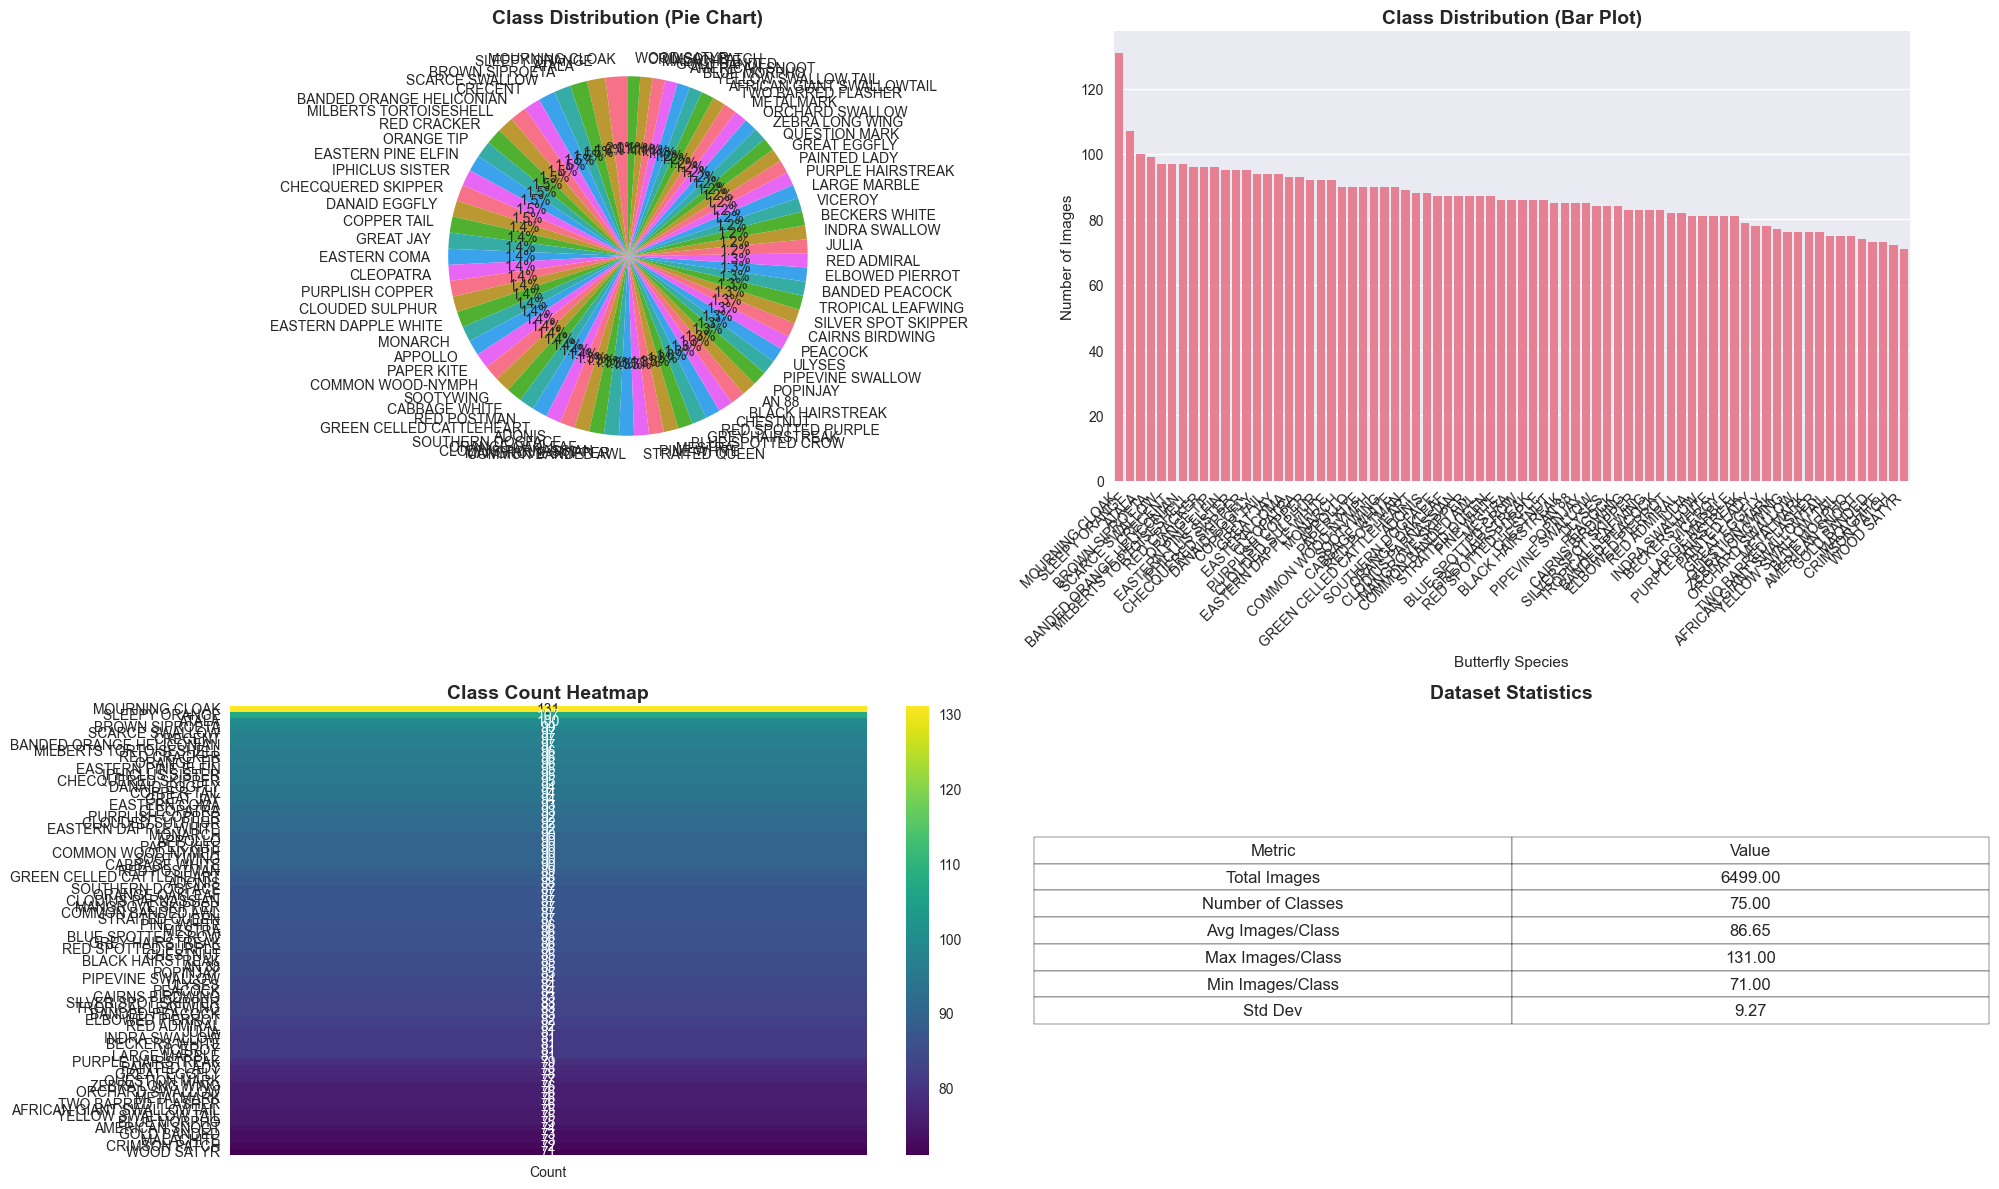

Classes: ['SOUTHERN DOGFACE', 'ADONIS', 'BROWN SIPROETA', 'MONARCH', 'GREEN CELLED CATTLEHEART', 'CAIRNS BIRDWING', 'EASTERN DAPPLE WHITE', 'RED POSTMAN', 'MANGROVE SKIPPER', 'BLACK HAIRSTREAK', 'CABBAGE WHITE', 'RED ADMIRAL', 'PAINTED LADY', 'PAPER KITE', 'SOOTYWING', 'PINE WHITE', 'PEACOCK', 'CHECQUERED SKIPPER', 'JULIA', 'COMMON WOOD-NYMPH', 'BLUE MORPHO', 'CLOUDED SULPHUR', 'STRAITED QUEEN', 'ORANGE OAKLEAF', 'PURPLISH COPPER', 'ATALA', 'IPHICLUS SISTER', 'DANAID EGGFLY', 'LARGE MARBLE', 'PIPEVINE SWALLOW', 'BLUE SPOTTED CROW', 'RED CRACKER', 'QUESTION MARK', 'CRIMSON PATCH', 'BANDED PEACOCK', 'SCARCE SWALLOW', 'COPPER TAIL', 'GREAT JAY', 'INDRA SWALLOW', 'VICEROY', 'MALACHITE', 'APPOLLO', 'TWO BARRED FLASHER', 'MOURNING CLOAK', 'TROPICAL LEAFWING', 'POPINJAY', 'ORANGE TIP', 'GOLD BANDED', 'BECKERS WHITE', 'RED SPOTTED PURPLE', 'MILBERTS TORTOISESHELL', 'SILVER SPOT SKIPPER', 'AMERICAN SNOOT', 'AN 88', 'ULYSES', 'COMMON BANDED AWL', 'CRECENT', 'METALMARK', 'SLEEPY ORANGE', 'PURPLE 

In [52]:

fig, axes = plt.subplots(2, 2, figsize=(20, 12))


axes[0, 0].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')


sns.countplot(data=train_df, x="label", order=train_df['label'].value_counts().index, ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('Class Distribution (Bar Plot)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Butterfly Species')
axes[0, 1].set_ylabel('Number of Images')


class_matrix = class_counts.values.reshape(-1, 1)
sns.heatmap(class_matrix, annot=True, fmt='d', cmap='viridis', 
            yticklabels=class_counts.index, xticklabels=['Count'], ax=axes[1, 0])
axes[1, 0].set_title('Class Count Heatmap', fontsize=14, fontweight='bold')


stats_data = {
    'Metric': ['Total Images', 'Number of Classes', 'Avg Images/Class', 
               'Max Images/Class', 'Min Images/Class', 'Std Dev'],
    'Value': [len(train_df), train_df['label'].nunique(), 
              class_counts.mean(), class_counts.max(), 
              class_counts.min(), class_counts.std()]
}
stats_df = pd.DataFrame(stats_data)


axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=[[f"{val:.2f}" if isinstance(val, float) else str(val) 
                                  for val in row] for row in stats_df.values],
                        colLabels=stats_df.columns,
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Dataset Statistics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/class_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Classes: {list(train_df['label'].unique())}")

In [53]:

print("APPLYING DATA BALANCING:")
print("="*40)


original_counts = train_df['label'].value_counts()
print(f"Original class distribution:\n{original_counts}")


max_count = original_counts.max()
print(f"\nBalancing all classes to {max_count} samples each...")

balanced_dfs = []
balancing_stats = {}

for label, group in train_df.groupby('label'):
    original_size = len(group)
    
    if original_size < max_count:
        oversampled_group = resample(group, 
                                   replace=True, 
                                   n_samples=max_count, 
                                   random_state=42)
        balanced_dfs.append(oversampled_group)
        balancing_stats[label] = {
            'original': original_size,
            'balanced': max_count,
            'added': max_count - original_size,
            'method': 'oversampled'
        }
    else:
        balanced_dfs.append(group)
        balancing_stats[label] = {
            'original': original_size,
            'balanced': original_size,
            'added': 0,
            'method': 'unchanged'
        }

balanced_train_df = pd.concat(balanced_dfs, ignore_index=True)


balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nBalancing completed!")
print(f"Original dataset size: {len(train_df)}")
print(f"Balanced dataset size: {len(balanced_train_df)}")


print(f"\nBalancing Statistics:")
for label, stats in balancing_stats.items():
    print(f"{label}: {stats['original']} → {stats['balanced']} "
          f"(+{stats['added']}, {stats['method']})")

print(f"\nFinal class distribution:")
final_counts = balanced_train_df['label'].value_counts()
print(final_counts)

APPLYING DATA BALANCING:
Original class distribution:
label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
SCARCE SWALLOW     97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

Balancing all classes to 131 samples each...

Balancing completed!
Original dataset size: 6499
Balanced dataset size: 9825

Balancing Statistics:
ADONIS: 88 → 131 (+43, oversampled)
AFRICAN GIANT SWALLOWTAIL: 75 → 131 (+56, oversampled)
AMERICAN SNOOT: 74 → 131 (+57, oversampled)
AN 88: 85 → 131 (+46, oversampled)
APPOLLO: 90 → 131 (+41, oversampled)
ATALA: 100 → 131 (+31, oversampled)
BANDED ORANGE HELICONIAN: 97 → 131 (+34, oversampled)
BANDED PEACOCK: 83 → 131 (+48, oversampled)
BECKERS WHITE: 81 → 131 (+50, oversampled)
BLACK HAIRSTREAK: 85 → 131 (+46, oversampled)
BLUE MORPHO: 75 → 131 (+56, oversampled)
BLUE SPOTTED CROW: 86 → 131 (+45, oversamp

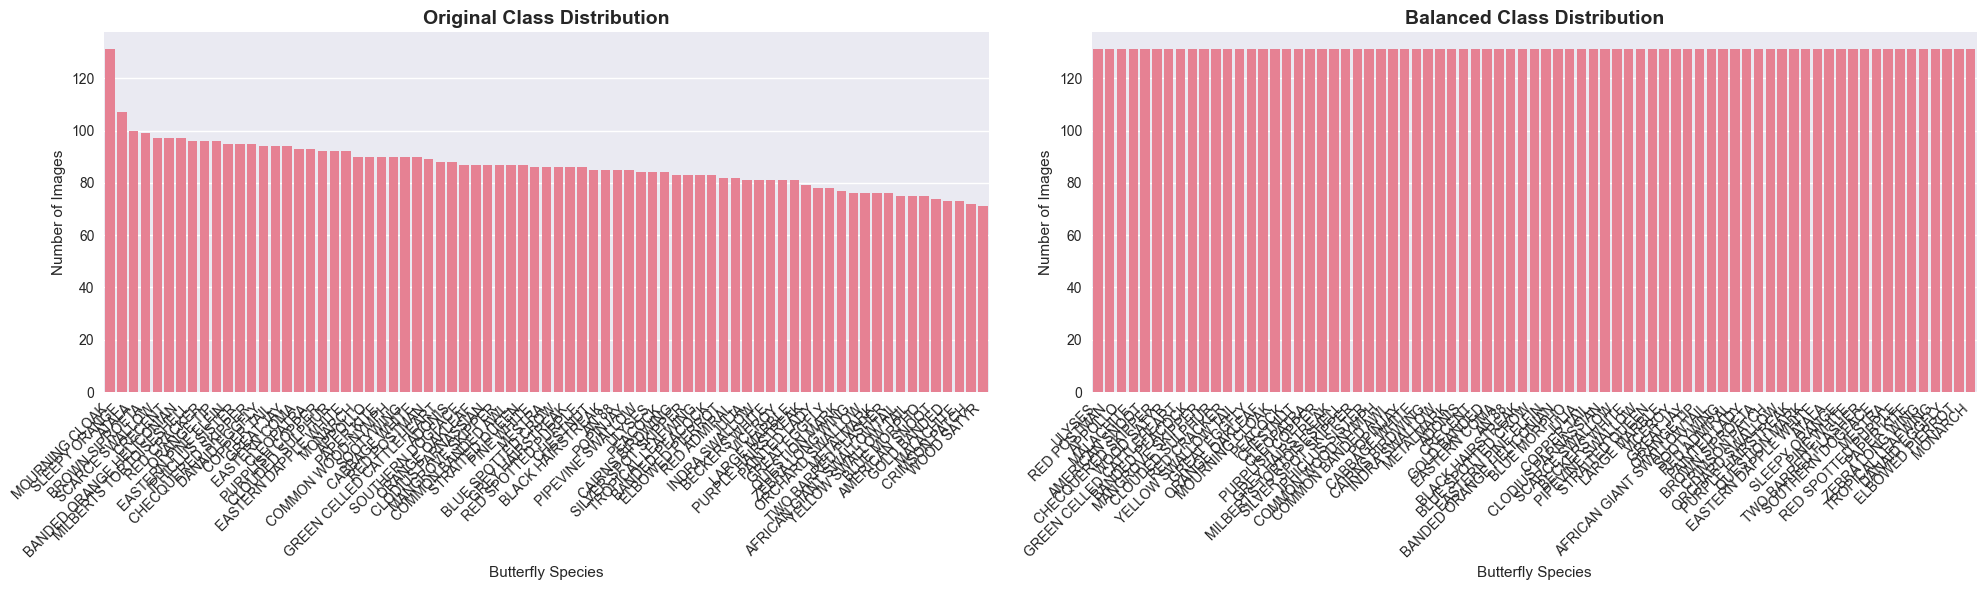

Balancing Improvement:
Original standard deviation: 9.27
Balanced standard deviation: 0.00
Improvement: 100.0% reduction in class imbalance


In [54]:

fig, axes = plt.subplots(1, 2, figsize=(20, 6))


sns.countplot(data=train_df, x="label", order=train_df['label'].value_counts().index, ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Original Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Butterfly Species')
axes[0].set_ylabel('Number of Images')


sns.countplot(data=balanced_train_df, x="label", order=balanced_train_df['label'].value_counts().index, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Balanced Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Butterfly Species')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.savefig('results/balanced_vs_original_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


original_std = original_counts.std()
balanced_std = final_counts.std()
improvement = ((original_std - balanced_std) / original_std) * 100

print(f"Balancing Improvement:")
print(f"Original standard deviation: {original_std:.2f}")
print(f"Balanced standard deviation: {balanced_std:.2f}")
print(f"Improvement: {improvement:.1f}% reduction in class imbalance")

DISPLAYING SAMPLE IMAGES:


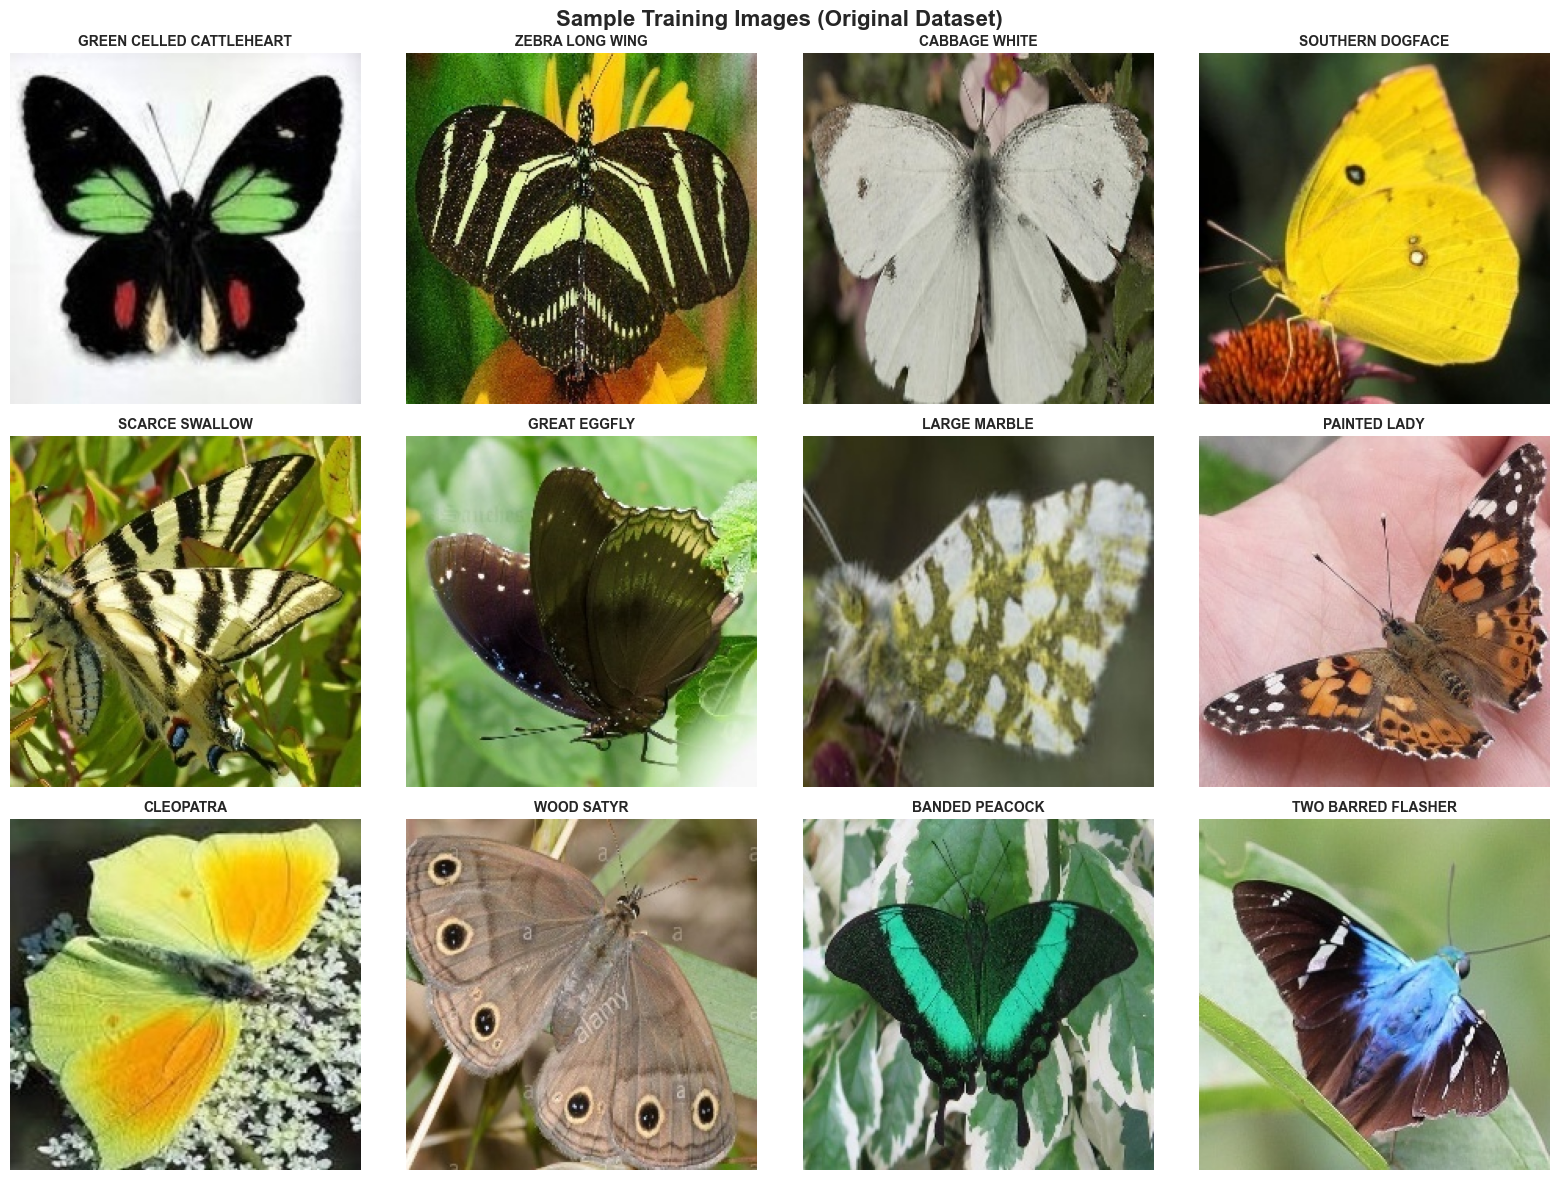

 Successfully loaded 12/12 images


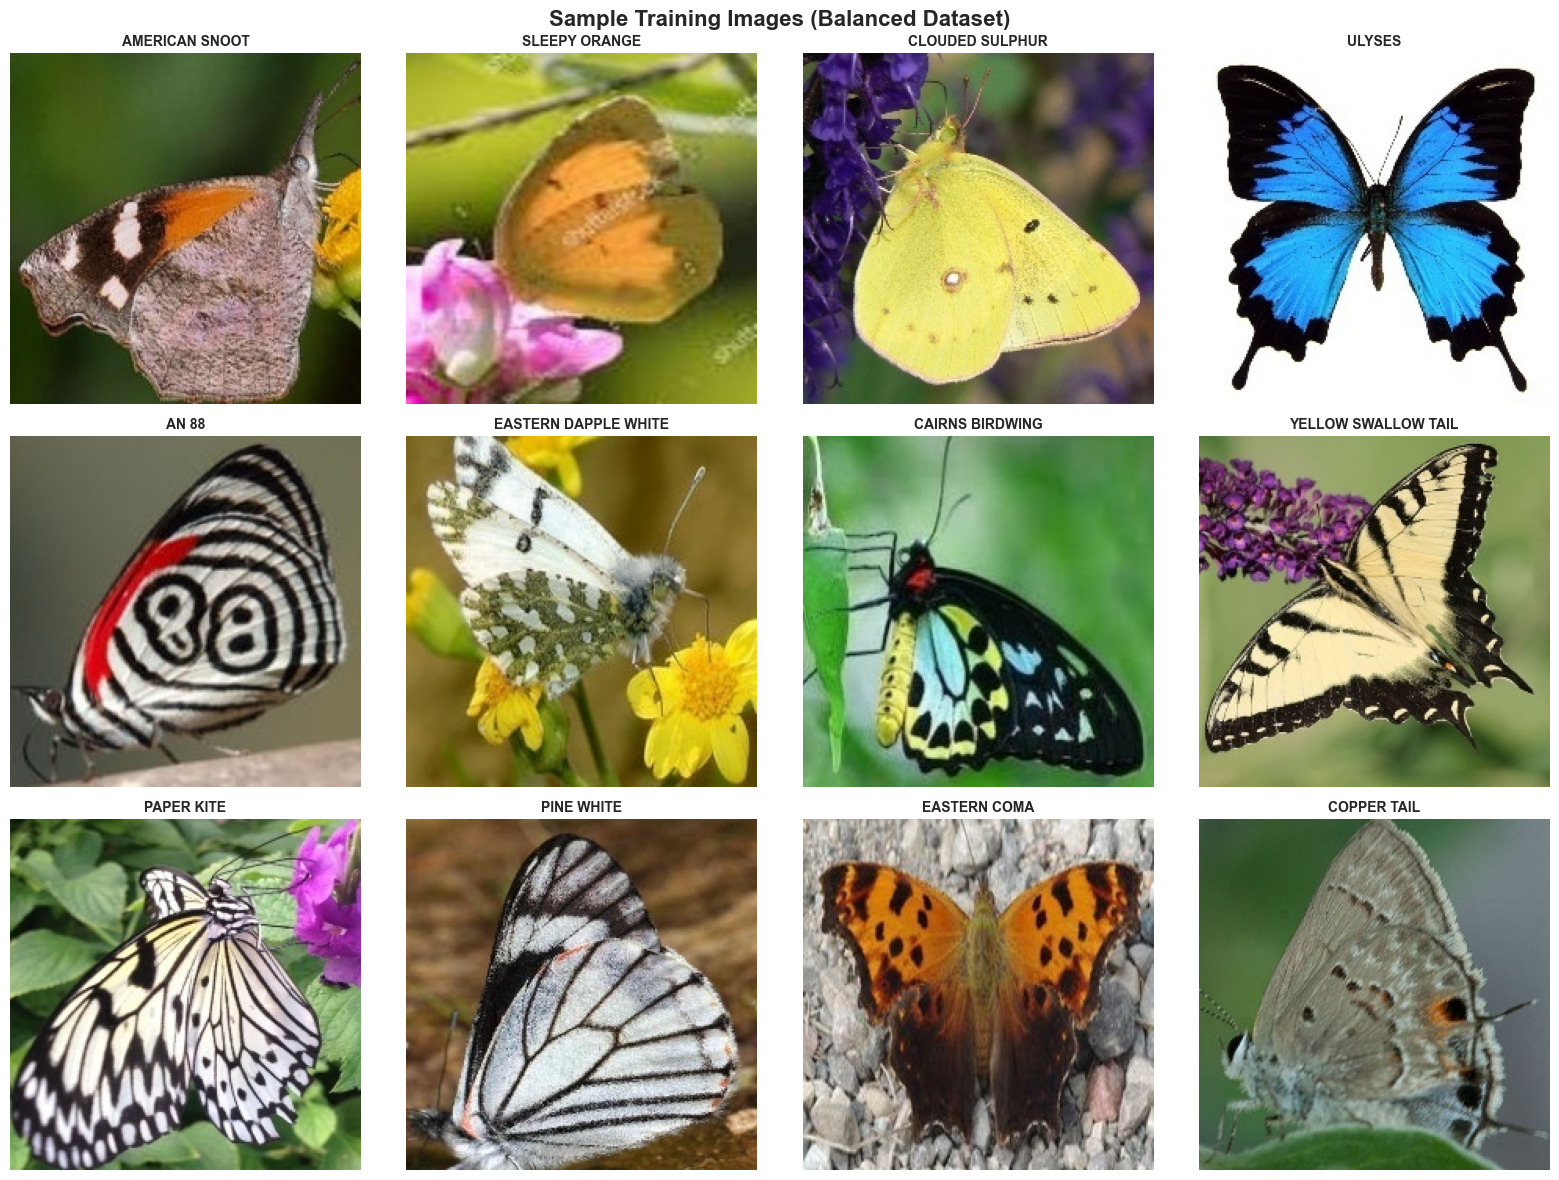

 Successfully loaded 12/12 images


In [55]:


print("DISPLAYING SAMPLE IMAGES:")
print("="*40)


def display_sample_images(df, title, n_samples=12, random_state=42):
    """Display sample images from the dataset"""
    
    
    samples_per_class = max(1, n_samples // df['label'].nunique())
    sample_dfs = []
    
    for label in df['label'].unique():
        class_df = df[df['label'] == label]
        n_to_sample = min(samples_per_class, len(class_df))
        sample_dfs.append(class_df.sample(n=n_to_sample, random_state=random_state))
    
    sample_df = pd.concat(sample_dfs).sample(n=min(n_samples, len(pd.concat(sample_dfs))), 
                                           random_state=random_state)
    

    cols = 4
    rows = (len(sample_df) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    loaded_count = 0
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        if idx >= n_samples:
            break
            
        img_path = os.path.join(DATA_DIR, "train", row['filename'])
        r, c = idx // cols, idx % cols
        
        try:
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f"{row['label']}", fontsize=10, fontweight='bold')
                axes[r, c].axis('off')
                loaded_count += 1
            else:
                axes[r, c].text(0.5, 0.5, f"Image not found\n{row['filename']}", 
                              ha='center', va='center', transform=axes[r, c].transAxes)
                axes[r, c].axis('off')
        except Exception as e:
            axes[r, c].text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                          ha='center', va='center', transform=axes[r, c].transAxes)
            axes[r, c].axis('off')
            print(f"❌ Error loading {row['filename']}: {e}")
    
    
    for idx in range(len(sample_df), rows * cols):
        r, c = idx // cols, idx % cols
        axes[r, c].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'results/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f" Successfully loaded {loaded_count}/{len(sample_df)} images")
    return loaded_count


original_loaded = display_sample_images(train_df, "Sample Training Images (Original Dataset)", n_samples=12)


balanced_loaded = display_sample_images(balanced_train_df, "Sample Training Images (Balanced Dataset)", n_samples=12)

In [56]:
print("PREPROCESSING SETUP:")
print("="*40)


IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

print(f"Image dimensions: {IMAGE_SIZE}x{IMAGE_SIZE}x{CHANNELS}")
print(f"Batch size: {BATCH_SIZE}")


label_encoder = LabelEncoder()
balanced_train_df['label_encoded'] = label_encoder.fit_transform(balanced_train_df['label'])
num_classes = len(label_encoder.classes_)

print(f"\nLABEL ENCODING:")
print(f"Number of classes: {num_classes}")
print(f"Class mapping:")
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"  {idx}: {class_name}")


print(f"\nEncoding verification:")
print(f"Original labels sample: {balanced_train_df['label'].head().tolist()}")
print(f"Encoded labels sample: {balanced_train_df['label_encoded'].head().tolist()}")


import joblib
joblib.dump(label_encoder, 'models/label_encoder.pkl')
print(f"\n Label encoder saved to 'models/label_encoder.pkl'")


from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(balanced_train_df['label_encoded']), 
                                   y=balanced_train_df['label_encoded'])
class_weight_dict = dict(enumerate(class_weights))
print(f"\n Class weights: {class_weight_dict}")

PREPROCESSING SETUP:
Image dimensions: 128x128x3
Batch size: 32

LABEL ENCODING:
Number of classes: 75
Class mapping:
  0: ADONIS
  1: AFRICAN GIANT SWALLOWTAIL
  2: AMERICAN SNOOT
  3: AN 88
  4: APPOLLO
  5: ATALA
  6: BANDED ORANGE HELICONIAN
  7: BANDED PEACOCK
  8: BECKERS WHITE
  9: BLACK HAIRSTREAK
  10: BLUE MORPHO
  11: BLUE SPOTTED CROW
  12: BROWN SIPROETA
  13: CABBAGE WHITE
  14: CAIRNS BIRDWING
  15: CHECQUERED SKIPPER
  16: CHESTNUT
  17: CLEOPATRA
  18: CLODIUS PARNASSIAN
  19: CLOUDED SULPHUR
  20: COMMON BANDED AWL
  21: COMMON WOOD-NYMPH
  22: COPPER TAIL
  23: CRECENT
  24: CRIMSON PATCH
  25: DANAID EGGFLY
  26: EASTERN COMA
  27: EASTERN DAPPLE WHITE
  28: EASTERN PINE ELFIN
  29: ELBOWED PIERROT
  30: GOLD BANDED
  31: GREAT EGGFLY
  32: GREAT JAY
  33: GREEN CELLED CATTLEHEART
  34: GREY HAIRSTREAK
  35: INDRA SWALLOW
  36: IPHICLUS SISTER
  37: JULIA
  38: LARGE MARBLE
  39: MALACHITE
  40: MANGROVE SKIPPER
  41: MESTRA
  42: METALMARK
  43: MILBERTS TORTOISESH

In [57]:

def load_and_preprocess_images(df, folder_path, is_training=True, show_progress=True):
   
    
    images = []
    labels = []
    failed_images = []
    
    print(f"Loading images from: {folder_path}")
    print(f"Processing {len(df)} images...")
    
    
    iterator = tqdm(df.iterrows(), total=len(df), desc="Loading images") if show_progress else df.iterrows()
    
    for idx, row in iterator:
        img_path = os.path.join(folder_path, row['filename'])
        
        try:
            
            if not os.path.exists(img_path):
                failed_images.append({'filename': row['filename'], 'error': 'File not found'})
                continue
            
            
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
            

            img_array = img_to_array(img)
            img_array = img_array.astype('float32') / 255.0
            
            
            if img_array.shape != (IMAGE_SIZE, IMAGE_SIZE, CHANNELS):
                failed_images.append({'filename': row['filename'], 
                                    'error': f'Invalid shape: {img_array.shape}'})
                continue
            
            images.append(img_array)
            
            
            if is_training:
                labels.append(row['label_encoded'])
                
        except Exception as e:
            failed_images.append({'filename': row['filename'], 'error': str(e)})
            continue
    
    
    images = np.array(images, dtype='float32')
    
    if is_training:
        labels = np.array(labels, dtype='int32')
        labels_categorical = to_categorical(labels, num_classes=num_classes)
    
    
    print(f"\nLoading completed!")
    print(f"Successfully loaded: {len(images)} images")
    print(f"Failed to load: {len(failed_images)} images")
    
    if failed_images:
        print(f"Failed images details:")
        for fail in failed_images[:5]:  # Show first 5 failures
            print(f"   - {fail['filename']}: {fail['error']}")
        if len(failed_images) > 5:
            print(f"   ... and {len(failed_images) - 5} more")
    
    
    print(f"\nFinal data shape:")
    print(f"Images: {images.shape}")
    if is_training:
        print(f"Labels: {labels_categorical.shape}")
        print(f"Label distribution: {np.bincount(labels)}")
    
    if is_training:
        return images, labels_categorical
    else:
        return images


print("LOADING TRAINING DATA:")
print("="*50)
X_train, y_train = load_and_preprocess_images(
    balanced_train_df, 
    os.path.join(DATA_DIR, "train"), 
    is_training=True
)


print(f"\nLOADING TEST DATA:")
print("="*50)
X_test = load_and_preprocess_images(
    test_df, 
    os.path.join(DATA_DIR, "test"), 
    is_training=False
)


print(f"\nSaving processed data...")
np.save('models/X_train.npy', X_train)
np.save('models/y_train.npy', y_train)
np.save('models/X_test.npy', X_test)
print(f"✅ Data saved to 'models/' directory")

LOADING TRAINING DATA:
Loading images from: data\train
Processing 9825 images...


Loading images:   0%|          | 27/9825 [00:00<00:41, 237.99it/s]

Loading images: 100%|██████████| 9825/9825 [00:21<00:00, 447.62it/s]




Loading completed!
Successfully loaded: 9825 images
Failed to load: 0 images

Final data shape:
Images: (9825, 128, 128, 3)
Labels: (9825, 75)
Label distribution: [131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131
 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131
 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131
 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131 131
 131 131 131]

LOADING TEST DATA:
Loading images from: data\test
Processing 2786 images...

LOADING TEST DATA:
Loading images from: data\test
Processing 2786 images...


Loading images: 100%|██████████| 2786/2786 [00:07<00:00, 384.91it/s]




Loading completed!
Successfully loaded: 2786 images
Failed to load: 0 images

Final data shape:
Images: (2786, 128, 128, 3)

Saving processed data...
✅ Data saved to 'models/' directory
✅ Data saved to 'models/' directory


In [63]:



train_datagen = ImageDataGenerator(
    rescale=1.0, 
    
    
    rotation_range=20,         
    width_shift_range=0.15,      
    height_shift_range=0.15,     
    shear_range=0.1,             
    zoom_range=0.15,             
    horizontal_flip=True,        
    
    
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.1
    
    
    validation_split=0.2,       
    
    
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1.0,
    validation_split=0.2
)



train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    seed=42
)


print(f"   - Training samples: {train_generator.n}")
print(f"   - Validation samples: {validation_generator.n}")
print(f"   - Training batches per epoch: {len(train_generator)}")
print(f"   - Validation batches per epoch: {len(validation_generator)}")



sample_batch_x, sample_batch_y = next(train_generator)
print(f"   - Batch shape: {sample_batch_x.shape}")
print(f"   - Label shape: {sample_batch_y.shape}")
print(f"   - Data type: {sample_batch_x.dtype}")
print(f"   - Data range: [{sample_batch_x.min():.3f}, {sample_batch_x.max():.3f}]")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1014327663.py, line 14)

In [ ]:

tf.keras.backend.clear_session()

def create_advanced_cnn_model(input_shape, num_classes):
    
    
    model = Sequential([
        
        tf.keras.layers.Input(shape=input_shape),
        
    
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv1_1'),
        BatchNormalization(name='bn1_1'),
        Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv1_2'),
        BatchNormalization(name='bn1_2'),
        MaxPooling2D((2, 2), name='pool1'),
        Dropout(0.25, name='dropout1'),
        
        
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv2_1'),
        BatchNormalization(name='bn2_1'),
        Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv2_2'),
        BatchNormalization(name='bn2_2'),
        MaxPooling2D((2, 2), name='pool2'),
        Dropout(0.25, name='dropout2'),
        
        
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv3_1'),
        BatchNormalization(name='bn3_1'),
        Conv2D(128, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv3_2'),
        BatchNormalization(name='bn3_2'),
        MaxPooling2D((2, 2), name='pool3'),
        Dropout(0.25, name='dropout3'),
        
        
        Conv2D(256, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv4_1'),
        BatchNormalization(name='bn4_1'),
        Conv2D(256, (3, 3), activation='relu', padding='same', 
               kernel_initializer='he_normal', name='conv4_2'),
        BatchNormalization(name='bn4_2'),
        
        
        GlobalAveragePooling2D(name='global_avg_pool'),
        
        
        Dense(512, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001), name='dense1'),
        BatchNormalization(name='bn_dense1'),
        Dropout(0.5, name='dropout_dense1'),
        
        Dense(256, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=l2(0.001), name='dense2'),
        BatchNormalization(name='bn_dense2'),
        Dropout(0.5, name='dropout_dense2'),
        
        # Output layer
        Dense(num_classes, activation='softmax', 
              kernel_initializer='glorot_normal', name='predictions')
    ])
    
    return model

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = create_advanced_cnn_model(input_shape, num_classes)

optimizer = Adam(
    learning_rate=0.001,        
    beta_1=0.9,                
    beta_2=0.999,             
    epsilon=1e-07,              
    amsgrad=False              
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_3_accuracy']  # Added top-3 accuracy
)


model.summary()


total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params


print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Non-trainable parameters: {non_trainable_params:,}")
print(f"   - Model size (approx): {total_params * 4 / (1024**2):.2f} MB")


with open('models/model_architecture.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print(f"\nModel architecture saved to 'models/model_architecture.txt'")

c:\Users\Admin\anaconda3\Anaconda\envs\anaconda2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:


callbacks_list = []

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                
    restore_best_weights=True, 
    verbose=1,
    mode='max'                  
)
callbacks_list.append(early_stopping)


lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                 
    patience=5,                 
    min_lr=1e-7,               
    verbose=1,
    mode='min'
)
callbacks_list.append(lr_reducer)


checkpoint = ModelCheckpoint(
    filepath='models/best_butterfly_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
callbacks_list.append(checkpoint)


class TrainingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_logs = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_logs.append(logs)
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\nEpoch {epoch + 1} Summary:")
            print(f"   - Training Accuracy: {logs['accuracy']:.4f}")
            print(f"   - Validation Accuracy: {logs['val_accuracy']:.4f}")
            print(f"   - Training Loss: {logs['loss']:.4f}")
            print(f"   - Validation Loss: {logs['val_loss']:.4f}")

training_monitor = TrainingMonitor()
callbacks_list.append(training_monitor)

print("Callbacks configured:")
print(f"   - Early Stopping: monitor='val_accuracy', patience=10")
print(f"   - Learning Rate Reduction: factor=0.5, patience=5")
print(f"   - Model Checkpoint: save best model based on val_accuracy")
print(f"   - Training Monitor: progress tracking every 5 epochs")

EPOCHS = 100  
VERBOSE = 1   

print(f"\nTraining Configuration:")
print(f"   - Maximum epochs: {EPOCHS}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"   - Number of classes: {num_classes}")
print(f"   - Training samples: {train_generator.n}")
print(f"   - Validation samples: {validation_generator.n}")

Callbacks configured:
   - Early Stopping: monitor='val_accuracy', patience=10
   - Learning Rate Reduction: factor=0.5, patience=5
   - Model Checkpoint: save best model based on val_accuracy
   - Training Monitor: progress tracking every 5 epochs

Training Configuration:
   - Maximum epochs: 100
   - Batch size: 32
   - Image size: 128x128
   - Number of classes: 75


NameError: name 'train_generator' is not defined